In [1]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_addons as tfa

from sklearn.metrics import *
import scikitplot as skplt

from functools import partial
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
data = pd.read_csv('D:/semester3/original_100/Folds.csv')
img_dir = 'D:/semester3/original_100/'
class_names = ['benign', 'malignant']

In [3]:
data

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
...,...,...,...,...
39540,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...
39541,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...
39542,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...
39543,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...


In [4]:
data = data.loc[(data['mag'] == 100) & (data['fold']==1)] 

In [5]:
data

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
...,...,...,...,...
7806,1,100,test,BreaKHis_v1/histology_slides/breast/malignant/...
7807,1,100,test,BreaKHis_v1/histology_slides/breast/malignant/...
7808,1,100,test,BreaKHis_v1/histology_slides/breast/malignant/...
7809,1,100,test,BreaKHis_v1/histology_slides/breast/malignant/...


In [6]:
data = data.rename(columns={'filename':'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])
data.head(3)

,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-003.png


In [7]:
data.to_csv('D:/semester3/original_100/original_updated_fold_100_v2.csv')

In [8]:
original_data_updated_100 = pd.read_csv('D:/semester3/original_100/original_updated_fold_100_v2.csv')

Count of Benign    :  644
Count of Malignant :  1437


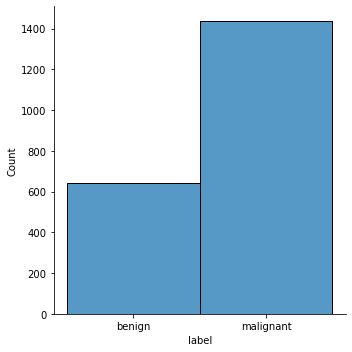

In [9]:
ax = sns.displot(data=original_data_updated_100, x=original_data_updated_100['label'])
print('Count of Benign    : ', original_data_updated_100[original_data_updated_100.label == 'benign'].label.count())
print('Count of Malignant : ', original_data_updated_100[original_data_updated_100.label == 'malignant'].label.count())

In [10]:
test_df = original_data_updated_100.groupby('label').sample(frac=0.2)
train_df = original_data_updated_100.drop(test_df.index).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# split training and validation set
valid_df = train_df.sample(frac=0.1)
train_df = train_df.drop(valid_df.index).reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

test_df['set'] = 'test'
train_df['set'] = 'train'
valid_df['set'] = 'valid'
data_new = pd.concat([train_df,valid_df, test_df])
print(data_new)

# ax = sns.displot(data=data_new, x='label', col='set')

print('Training set')
print(train_df.label.value_counts())

print('\nValidation set')
print(valid_df.label.value_counts())

print('\nTest set')
print(test_df.label.value_counts())

     Unnamed: 0  fold  mag    grp  \
0             0     1  100  train   
1             1     1  100  train   
2             2     1  100  train   
3             3     1  100  train   
4             4     1  100  train   
..          ...   ...  ...    ...   
411        7663     1  100   test   
412        1842     1  100  train   
413        2364     1  100  train   
414        2709     1  100  train   
415        2506     1  100  train   

                                                  path      label  label_int  \
0    BreaKHis_v1/histology_slides/breast/benign/SOB...     benign          0   
1    BreaKHis_v1/histology_slides/breast/benign/SOB...     benign          0   
2    BreaKHis_v1/histology_slides/breast/benign/SOB...     benign          0   
3    BreaKHis_v1/histology_slides/breast/benign/SOB...     benign          0   
4    BreaKHis_v1/histology_slides/breast/benign/SOB...     benign          0   
..                                                 ...        ...        ..

In [11]:
print(train_df.label.value_counts())

malignant    1035
benign        464
Name: label, dtype: int64


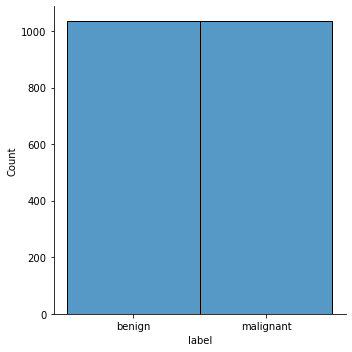

In [12]:
# upsampling training dataset
max_count = np.max(train_df.label.value_counts())
min_count = np.min(train_df.label.value_counts())
train_df = train_df.groupby('label').sample(n=max_count, replace=True)
train_df = train_df.reset_index(drop=True)
train_df.label.value_counts()

ax = sns.displot(data=train_df, x=train_df['label'])

In [13]:
train_loader = tf.data.Dataset.from_tensor_slices((img_dir+train_df.path, train_df.label_int))
valid_loader = tf.data.Dataset.from_tensor_slices((img_dir+valid_df.path, valid_df.label_int))
test_loader=tf.data.Dataset.from_tensor_slices((img_dir+test_df.path, test_df.label_int))

In [14]:
model_handle_map = {

 "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

}


model_image_size_map = {

 "efficientnet_b0": 224

}

In [15]:
model_name = 'efficientnet_b0'
model_handle = model_handle_map.get(model_name)
IMAGE_SIZE = model_image_size_map.get(model_name, 224)
BATCH_SIZE = 64
EPOCHS = 12
SAMPLE_SIZE = len(train_df)

print(f"Selected model: {model_name} : {model_handle}")
print(f"Input size {IMAGE_SIZE}")

Selected model: efficientnet_b0 : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Input size 224


In [16]:
def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label

In [17]:
def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])/255
    return img, label

In [21]:
train_loader = tf.data.Dataset.from_tensor_slices((img_dir+train_df.path, train_df.label_int))
valid_loader = tf.data.Dataset.from_tensor_slices((img_dir+valid_df.path, valid_df.label_int))

train_ds = (
    train_loader.shuffle(len(train_df))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
#     .map(partial(augmentor),num_parallel_calls=AUTOTUNE)
    .map(resize_rescale, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE) 
)
valid_ds = (
    valid_loader.shuffle(len(valid_df))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(resize_rescale, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [22]:
def view_image(ds, col=8, row=2, size=(25,7)):
    plt.figure(figsize=size)
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    for images, labels in ds.take(1):
        for i in range(col*row):
            ax = plt.subplot(row, col, i + 1)
            shape = str(images[i].numpy().shape)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off") 
    plt.tight_layout
    return None

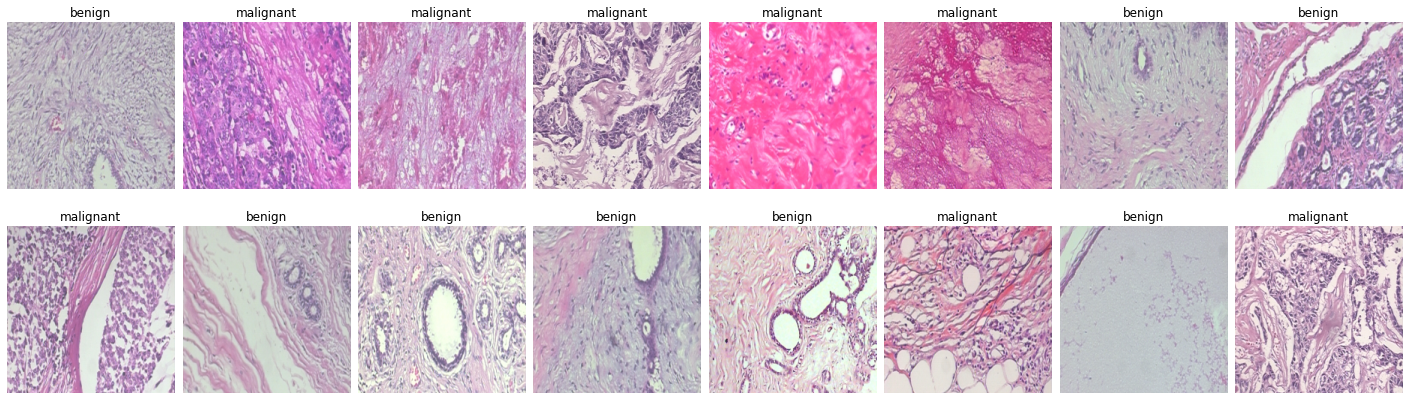

In [20]:
view_image(train_ds)

In [23]:
def build_network(image_size):
    print('building model...')
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(image_size, image_size, 3)),
        hub.KerasLayer(model_handle, trainable=True, name='base_model'),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid', name='classifier') 
    ],name=model_name)
    model.build((None, image_size, image_size, 3))
    model.summary()
    print('model loaded!!!')
    return model

In [25]:
tf.keras.backend.clear_session()
model = build_network(IMAGE_SIZE)

building model...
Model: "efficientnet_b0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_model (KerasLayer)     (None, 1280)              4049564   
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                 

In [26]:
checkpoint_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
clr_scheduler = tfa.optimizers.CyclicalLearningRate( 
    initial_learning_rate=2e-05,  maximal_learning_rate=7e-3, 
    step_size=3*(SAMPLE_SIZE//BATCH_SIZE),  
    scale_fn=lambda x: 1 / (2.0 ** (x - 1)), 
    scale_mode='cycle'
)
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),

]

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=clr_scheduler) , 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
)

history = model.fit(
    train_ds, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks = [checkpoint_cb],
    validation_data=valid_ds,
)

Epoch 1/12
33/33 [==============================] - 642s 18s/step - loss: 0.9796 - accuracy: 0.5372 - precision: 0.5355 - recall: 0.5604 - auc: 0.5369 - val_loss: 0.8256 - val_accuracy: 0.5422 - val_precision: 0.6893 - val_recall: 0.6174 - val_auc: 0.4983
Epoch 2/12
33/33 [==============================] - 607s 18s/step - loss: 0.8118 - accuracy: 0.6401 - precision: 0.6350 - recall: 0.6589 - auc: 0.6863 - val_loss: 0.7745 - val_accuracy: 0.6627 - val_precision: 0.7252 - val_recall: 0.8261 - val_auc: 0.6448
Epoch 3/12
33/33 [==============================] - 712s 22s/step - loss: 0.6373 - accuracy: 0.7522 - precision: 0.7426 - recall: 0.7720 - auc: 0.8328 - val_loss: 0.6840 - val_accuracy: 0.8072 - val_precision: 0.8120 - val_recall: 0.9391 - val_auc: 0.8366
Epoch 4/12
33/33 [==============================] - 744s 23s/step - loss: 0.5114 - accuracy: 0.8353 - precision: 0.8274 - recall: 0.8473 - auc: 0.9149 - val_loss: 0.6133 - val_accuracy: 0.8253 - val_precision: 0.8413 - val_recall: 0

In [27]:
def training_history(history):
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(len(history['loss']))

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()
    return None

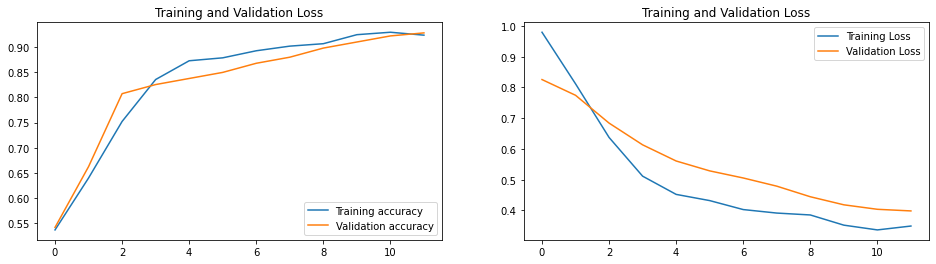

In [28]:
training_history(history.history)

In [29]:
def decode_test(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224, 224])/255
    return img

1/1 [==============================] - 19s 19s/step
              precision    recall  f1-score   support

      benign       0.87      0.74      0.80       129
   malignant       0.89      0.95      0.92       287

    accuracy                           0.88       416
   macro avg       0.88      0.84      0.86       416
weighted avg       0.88      0.88      0.88       416

f1_score        : 0.8846153846153846
accuracy_score  : 0.8846153846153846
precision_score  : 0.8892508143322475
recall_score  : 0.9512195121951219


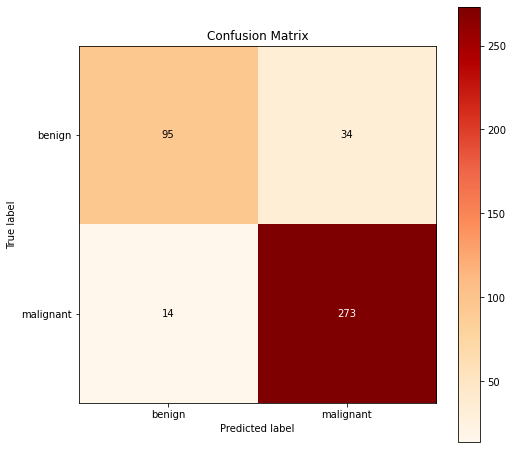

In [30]:
test_df = test_df.reset_index(drop=True)
test_ds = tf.data.Dataset.from_tensor_slices(img_dir+test_df.path) 
test_ds = test_ds.map(decode_test,num_parallel_calls=AUTOTUNE).batch(len(test_df))
test_img = next(iter(test_ds))
test_index = test_df.label_int.values
test_label = test_df.label.values

test_pred = model.predict(test_ds)
pred_index = np.round(test_pred).astype('uint8')
pred_label = np.array(class_names)[pred_index]

print(classification_report(test_index, pred_index, target_names=class_names,zero_division=0))
print('f1_score        :', f1_score(test_index, pred_index, average='micro'))
print('accuracy_score  :', accuracy_score(test_index, pred_index))
print('precision_score  :', precision_score(test_index, pred_index))
print('recall_score  :', recall_score(test_index, pred_index))

cm = skplt.metrics.plot_confusion_matrix(test_label, pred_label, figsize=(8, 8), normalize=False,cmap="OrRd")

In [31]:
print('f1_score        :', f1_score(test_index, pred_index))

f1_score        : 0.9191919191919191


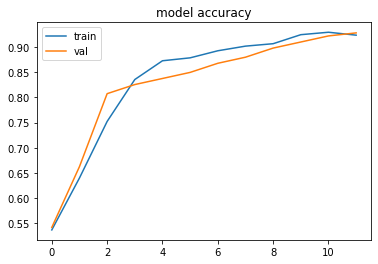

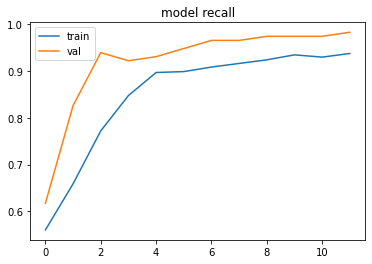

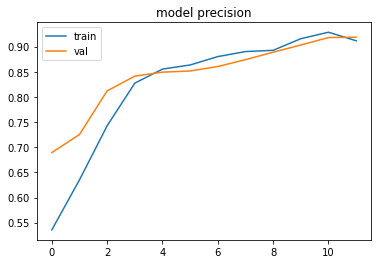

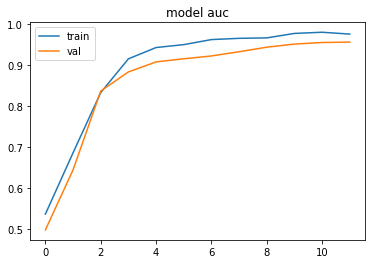

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#plt.plot(history.history['f1_score'])
#plt.plot(history.history['val_f1_score'])
#plt.title('model f1_score')
#plt.legend(['train', 'val'], loc='upper left')
#plt.show()